# Start Station Analysis

An introductory analysis of the stations that Citibike trips originate from.

### Import Packages

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
import os
%matplotlib inline

In [4]:
project_id = os.environ['project_id']

### Trip Data Overview Query

As a starting step, we take a look at some aggregate values of the underlying data. As shown below, there are 53,862,077 total trips recorded with an average trip duration of 947.7 seconds for the period of July 2013 to December 2017. Additionally, 18,559 distinct bikes have been used during this period, which is approximately 2902 trips/bike. Interestingly, there is a discrepancy between number of start stations and end stations, suggesting that some stations are not used as starting locations. More investigative work would need to be done to confirm this hypothesis.

In [5]:
trips_query="""
SELECT COUNT(tripduration) as num_trip, AVG(tripduration) as avg_trip, COUNT(DISTINCT bikeid) as num_bike,
  COUNT(DISTINCT start_station_id) as num_start_station, COUNT(DISTINCT end_station_id) as num_end_station
FROM 
  [bigquery-public-data:new_york.citibike_trips],
  [citibike_tripdata.tripdata_2016_10_to_2017_12],
  [citibike_tripdata.tripdata_jc_2015_09_to_2017_12] 
"""

trips = gbq.read_gbq(query=trips_query,dialect ='legacy', project_id=project_id)
trips.head()

Requesting query... ok.
Job ID: 28f5c95e-b4f3-4a26-a144-7739e58bdf49
Query running...
Query done.
Processed: 1.6 GB Billed: 1.6 GB
Standard price: $0.01 USD

Retrieving results...
Got 1 rows.

Total time taken 3.12 s.
Finished at 2018-03-25 17:08:47.


,num_trip,avg_trip,num_bike,num_start_station,num_end_station
0,53862077,947.737651,18559,908,915


### Trip Data by Year Query

The above query could be broken down by year, as shown below. As the Citibike system has expanded over the years, ridership has increased as well, with 16,659,585 trips recorded for 2017. 

In [6]:
trips_by_year_query="""
SELECT COUNT(tripduration) as num_trip, AVG(tripduration) as avg_trip, COUNT(DISTINCT bikeid) as num_bike,
  COUNT(DISTINCT start_station_id) as num_start_station, COUNT(DISTINCT end_station_id) as num_end_station,
  YEAR(starttime) as trip_year
FROM 
  [bigquery-public-data:new_york.citibike_trips],
  [citibike_tripdata.tripdata_2016_10_to_2017_12],
  [citibike_tripdata.tripdata_jc_2015_09_to_2017_12]
GROUP BY trip_year ORDER BY trip_year
"""

trips_by_year = gbq.read_gbq(query=trips_by_year_query,dialect ='legacy', project_id=project_id)
trips_by_year.head()

Requesting query... ok.
Job ID: 87dbf624-260c-4596-884f-1901d284a915
Query running...
Query done.
Processed: 2.0 GB Billed: 2.0 GB
Standard price: $0.01 USD

Retrieving results...
Got 5 rows.

Total time taken 4.65 s.
Finished at 2018-03-25 17:17:54.


,num_trip,avg_trip,num_bike,num_start_station,num_end_station,trip_year
0,5037185,887.638411,6082,330,330,2013
1,8081216,851.175207,6319,332,332,2014
2,9990852,971.323531,8658,523,527,2015
3,14093239,957.823031,10654,701,704,2016
4,16659585,990.073293,14376,864,869,2017


### Start Stations Query

In the query below, we aggregate trip data such as number of trips (num_trip) and average trip duration (avg_trip) by start station for analysis. While aggregation by start station does not necessarily account for all stations, it is good enough for our purposes.

In [7]:
start_stations_query="""
SELECT start_station_id, start_station_name, start_station_latitude, start_station_longitude,
COUNT(tripduration) as num_trip, AVG(tripduration) as avg_trip 
FROM 
  [bigquery-public-data:new_york.citibike_trips],
  [citibike_tripdata.tripdata_2016_10_to_2017_12],
  [citibike_tripdata.tripdata_jc_2015_09_to_2017_12] 
GROUP BY start_station_id, start_station_name, start_station_latitude, start_station_longitude ORDER BY num_trip DESC
"""

start_stations = gbq.read_gbq(query=start_stations_query,dialect ='legacy', project_id=project_id)
start_stations.head()

Requesting query... ok.
Job ID: e28641e3-2fd4-4c56-8cf5-0f369cbe635f
Query running...
Query done.
Cache hit.

Retrieving results...
Got 987 rows.

Total time taken 1.58 s.
Finished at 2018-03-25 17:23:57.


,start_station_id,start_station_name,start_station_latitude,start_station_longitude,num_trip,avg_trip
0,519,Pershing Square North,40.751873,-73.977706,447528,841.747336
1,497,E 17 St & Broadway,40.737050,-73.990093,427728,797.162603
2,435,W 21 St & 6 Ave,40.741740,-73.994156,406831,722.300896
3,426,West St & Chambers St,40.717548,-74.013221,386478,1199.372288
4,402,Broadway & E 22 St,40.740343,-73.989551,369470,770.480486


### Data Cleaning

In order to plot a representation of NYC with Citibike (start) stations, we need to clean our DataFrame of questionable location data. We ignore all stations that have latitude and/or longitude of 0.0 as well as any with "8D" in their name for [8D Technologies](https://www.motivateco.com/bike-share-leaders-motivate-and-8d-technologies-announce-merger/). These are assumed to be test stations.

In [8]:
start_stations = start_stations[start_stations["start_station_latitude"] != 0.0]
print(start_stations.shape)
start_stations = start_stations[start_stations["start_station_longitude"] != 0.0]
print(start_stations.shape)
start_stations = start_stations[start_stations["start_station_name"].str[:2] != "8D"]
print(start_stations.shape)

(981, 6)
(981, 6)
(976, 6)


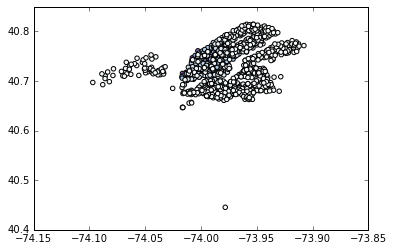

In [9]:
plt.scatter(x=start_stations['start_station_longitude'], y=start_stations['start_station_latitude'], 
            c=start_stations['num_trip'], cmap='BuPu')

We notice an outlier location and take a look at it. Since the number of trips is low, we decide to ignore it.

In [10]:
start_stations.loc[start_stations['start_station_latitude'] < 40.5]

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,num_trip,avg_trip
973,160,E 37 St & Lexington Ave,40.44535,-73.978238,8,569.75


In [11]:
start_stations = start_stations[start_stations["start_station_latitude"] > 40.5]
print(start_stations.shape)

(975, 6)


### NYC as Citibike Stations

Below is a scatterplot of Citibike (start) stations from July 2013 to December 2017 (including ones that have been removed/restored). In the below plot, NY can be visualized as parts of Manhattan, Brooklyn, Queens, and Jersey City. Certain regions of white space can be recognized as Central Park as well as the Hudson and East Rivers. A blue/purple color scheme is used for color ramping by number of trips (purple-high, blue-medium, white-low). A lot of Citibike activity seems to be centralized around Midtown and below.

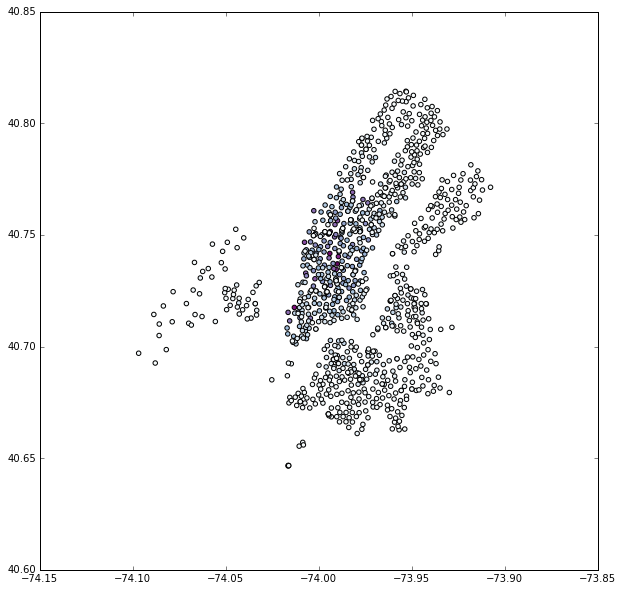

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(x=start_stations['start_station_longitude'], y=start_stations['start_station_latitude'], 
            c=start_stations['num_trip'], cmap='BuPu')

### Digging Deeper into Start Station Data

Below, we take a look into the descriptive statistics of our start station data. We notice that for both num_trip and avg_trip the standard deviations are larger than their respective means. Moreover, both have extremely wide ranges, as we shall visualize later on. In turn, there is high variability in the number of trips originating at a station and the average duration of those trips.

In [29]:
start_stations.describe()

,start_station_id,start_station_latitude,start_station_longitude,num_trip,avg_trip
count,975.000000,975.000000,975.000000,975.000000,975.000000
mean,2201.284103,40.731767,-73.977916,55242.990769,1245.241658
std,1434.541138,0.038211,0.030039,73911.406250,1855.504237
min,72.000000,40.646538,-74.096937,1.000000,178.000000
25%,435.500000,40.701575,-73.994491,4614.500000,812.912895
50%,3134.000000,40.729170,-73.977932,19512.000000,931.673839
75%,3378.500000,40.760252,-73.956189,84659.000000,1208.508559
max,3654.000000,40.814394,-73.907744,447528.000000,49716.277778


### Number of Trips per Station Boxplot

In the below boxplot of number of trips per (start) station, the majority of stations have approx. 200,000 total trips or less, with 75% of stations having 84,659 total trips or less. Nevertheless, there are several stations that deviate drastically from this majority, with the greatest outlier having 447,528 recorded trips. In turn, there is a substantial discrepancy between the median of 19,512 trips and the mean of 55,243 trips.

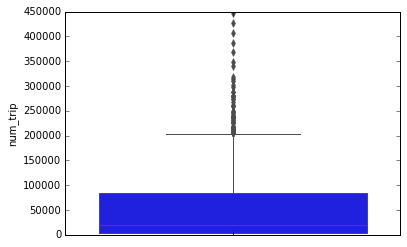

In [17]:
sns.boxplot(y=start_stations["num_trip"])

### Top 10 Start Stations by Number of Trips

Not surprisingly, certain stations have high usage due to proximity to landmarks and transit hubs. Pershing Square North, the station with the highest count, is next to Grand Central Terminal. E 17th St & Broadway is on the corner of Union Square. W 21 St & 6 Ave is close to Madison Square Park and the 23rd Street MTA stations. 

In [33]:
start_stations.sort_values('num_trip', ascending=False).head(10)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,num_trip,avg_trip
0,519,Pershing Square North,40.751873,-73.977706,447528,841.747336
1,497,E 17 St & Broadway,40.737050,-73.990093,427728,797.162603
2,435,W 21 St & 6 Ave,40.741740,-73.994156,406831,722.300896
3,426,West St & Chambers St,40.717548,-74.013221,386478,1199.372288
4,402,Broadway & E 22 St,40.740343,-73.989551,369470,770.480486
5,285,Broadway & E 14 St,40.734546,-73.990741,348109,737.188424
6,490,8 Ave & W 33 St,40.751551,-73.993934,340673,803.280923
7,459,W 20 St & 11 Ave,40.746745,-74.007756,318408,954.753788
8,477,W 41 St & 8 Ave,40.756405,-73.990026,314902,815.396457
9,368,Carmine St & 6 Ave,40.730386,-74.002150,309649,828.074094


### Average Trip Duration by Station Boxplot

Below is a boxplot of average trip duration by station. There are several outliers present within the boxplot, the most prominent having an average trip duration of 49716.3 seconds (828.6 minutes or 13 hours).

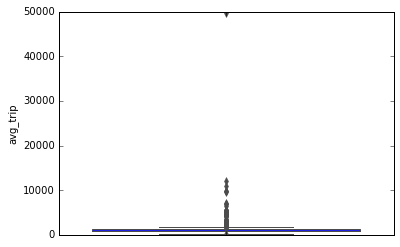

In [19]:
sns.boxplot(y=start_stations["avg_trip"])

### Start Stations with Average Trip Duration Above 45 Minutes

Since Citibike users are allowed 30-minute or 45-minute rides (depending on pricing plan), average trip durations for Citibike stations are expected to be below these limits. Below is a table of stations with average trip durations above 45 minutes. Surprisingly, there are 41 entries.

In [20]:
start_stations.loc[start_stations['avg_trip'] > 2700]

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,num_trip,avg_trip
531,3052,Lewis Ave & Madison St,40.686312,-73.935775,15344,4532.134385
541,3068,Humboldt St & Varet St,40.703172,-73.940636,14640,5566.343238
563,3067,Broadway & Whipple St,40.701666,-73.943730,13207,3119.595366
586,3047,Halsey St & Tompkins Ave,40.682369,-73.944118,12249,5018.287125
587,3042,Fulton St & Utica Ave,40.679427,-73.929891,12244,9922.021480
620,3050,Putnam Ave & Throop Ave,40.685153,-73.941110,10704,2776.620235
626,3058,Lewis Ave & Kosciuszko St,40.692371,-73.937054,10417,5063.008832
647,3046,Marcus Garvey Blvd & Macon St,40.682601,-73.938037,9215,4459.386869
656,3048,Putnam Ave & Nostrand Ave,40.684020,-73.949770,8536,2992.974695
660,3249,Verona Pl & Fulton St,40.680356,-73.947679,8234,6476.092665


In [35]:
start_stations.loc[start_stations['avg_trip'] > 2700].shape

(41, 6)

### Average Trip Duration by Station Modified Boxplot

We decide to regenerate our boxplot without stations that have average trip durations above an hour. While a significant number of entries are ignored (29 entries) due to this, we are able to visualize a more accurate representation of the average trip durations of the majority of stations. Moreover, this suggests that the tripduration variable of the overall trip data should be investigated (lost Citibikes could potentially be a key factor).

(946, 6)


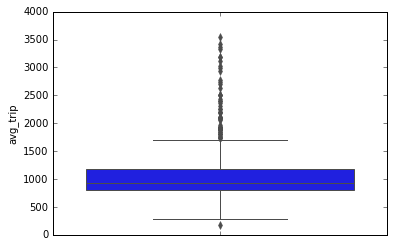

In [28]:
start_stations_ignore_outlier = start_stations[start_stations["avg_trip"] < 3600]
print(start_stations_ignore_outlier.shape)
sns.boxplot(y=start_stations_ignore_outlier["avg_trip"])